#### Executing this notebook depends on the Delta tables from project 1 being saved on DBFS!
In project 1, make sure to run chapters 1, 2, 3 fully to save the Delta tables. https://github.com/taidopurason/bdm-project-1/blob/main/transform_merged.ipynb

### Read data and extract relevant features

In [0]:
import pyspark.sql.functions as F
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Most of the data cleaning was already done in project 1 and here we load the cleaned data.

In [0]:
# Read the full dblp fact table.
dblp_df = (spark
           .read.load(f'dbfs:/user/dblpv13/dblp_full')
           .filter(F.col('Lang') == 'en')) # Keep only papers in English

The relevant features for recommending articles are FieldOfStudy, Keywords, Title, Abstract. Since the data was already cleaned in the first project, not much needs to be done here.

In [0]:
# Keep just the relevant features: FOS, Keywords, Title, Abstract.
data = dblp_df.select('FOS', 'Keywords', 'Title', 'Abstract')

# Drop all rows where any value is null.
data = data.na.drop()

# Keep only rows where title and abstract are longer than 1 word.
data = (data.filter( (F.size(F.split(data.Title, ' ')) > 1) & 
                     (F.size(F.split(data.Abstract, ' ')) > 1) ))

# Remove all empty (null or '') values from the FOS and Keywords arrays.
data = (data
        .withColumn('FOS', F.expr('filter(FOS, x -> x is not null)'))
        .withColumn('FOS', F.expr('filter(FOS, x -> length(x) > 0)'))
        .withColumn('Keywords', F.expr('filter(Keywords, x -> x is not null)'))
        .withColumn('Keywords', F.expr('filter(Keywords, x -> length(x) > 0)')))

logger.info(f'Before preprocessing, our data has {data.count()} samples.')

display(data.limit(10))

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection
INFO:__main__:Before preprocessing, our data has 1356788 samples.


FOS,Keywords,Title,Abstract
"List(Logic synthesis, Topology, Digital electronics, Boolean circuit, Sequential logic, Pass transistor logic, Logic optimization, Algorithm, Register-transfer level, High-level verification, Mathematics)","List(combinational circuits, formal verification, logic design, logic testing, network topology, SAT, combinational circuits, fixed circuit topology, formal verification, logic synthesis, logic verification, minimum ECO, net lists, test vector generation method)",Logic synthesis and verification on fixed topology,"We discuss about logic synthesis and formal verification of combinational circuits mapped to a given fixed topology. Here “fixed topology” means that circuit structures in terms of net lists except for gate/cell types are fixed in advance. That is, for logic synthesis, what should be generated are the types of gates/cells (or simply gates) in the circuits, and all the others are prefixed before synthesis. As the circuit topology is fixed in advance, placement and routing could be shared among different designs and minimum ECO can be realized by keeping the same layout. Also, we can show that we do not need many test vectors in order to guarantee 100% correctness of such synthesis. Small numbers of test vectors, such as only 100 test vectors for 30 input circuits, are sufficient to test if the circuits behave correctly for all possible input value combinations. That is, very efficient formal verification can be realized through simulations with small numbers of test vectors. We present SAT based implementation of the synthesis and a test vector generation method with preliminary but encouraging experimental results."
"List(Detection theory, Computer science, Inference, Algorithm, Artificial intelligence, Fuse (electrical), Machine learning, Recursion)","List(adaptive signal detection, compressed sensing, multidimensional signal processing, signal reconstruction, adaptive sequential compressive signal detection, compressive gain, multidimensional phenomena, nonadaptive strategy, recursive sparse reconstruction algorithm, sequential reconstruction, sparse signal detection, stopping criterion)",Adaptive sequential compressive detection,"Sparsity is at the heart of numerous applications dealing with multidimensional phenomena with low-information content. The primary question that this work investigates is whether, and how much, further compressive gains could be achieved if the goal of the inference task does not require exact reconstruction of the underlying signal. In particular, if the goal is to detect the existence of a sparse signal in noise, it is shown that the number of measurements can be reduced. In contrast to prior work, which considered non-adaptive strategies, a sequential adaptive approach for compressed signal detection is proposed. The key insight is that the decision can be made as soon as a stopping criterion is met during sequential reconstructions. Two sources of performance gains are studied, namely, compressive gains due to adaptation, and computational gains via recursive sparse reconstruction algorithms that fuse newly acquired measurements and previous signal estimates."
"List(Model order selection, Subspace topology, Computer science, Ordinal number, Ordinal data, Matrix decomposition, Speech recognition, Language acquisition, Artificial intelligence, Non-negative matrix factorization, Robot, Machine learning)","List(acoustic signal processing, audio user interfaces, human-robot interaction, intelligent robots, learning (artificial intelligence), matrix decomposition, CSNMF, accuracy improvement, acoustic data augmentation, automatic relevance, command execution, command meaning representation, constrained subspace NMF, grounding information, learning rate improvement, machine learning algorithm, model order selection, ordinal structure, ordinal word acquisition, robot learning, semantic labels, spoken utterances, vocal interface, weakly-supervised NMF, weakly-s

### Preprocessing
We do some baseline preprocessing here, and later perform data analysis to see what else needs to be done.

Load preprocessing libraries.

In [0]:
!pip install spacy

     |█████████████████▉           

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 9.9 MB 59.2 MB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 
     |████████████████████████████████| 96 kB 8.3 MB/s 
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
!python -m spacy download en_core_web_sm

     |█████████                       | 3.

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 12.8 MB 3.4 MB/s 
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [0]:
import spacy
import re
import string
from pyspark.sql.types import StringType, ArrayType, FloatType
from collections import Counter
import pyspark.sql.functions as F

In [0]:
nlp = spacy.load("en_core_web_sm")

These functions perform the preprocessing of Array or String type columns.

In [0]:
custom_stopwords = {'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'elsevier', 'pmc', 'czi', 'www', 'paper', '', 'like', 'able'}

def preprocess(text):
    # remove punctuation
    text = re.sub('[^\w\s]', ' ', text)
    # tokenize text and lowercase (stopwords are also in lowercase)
    text_tokens = [word.lower() for word in text.split(' ')]
    # keep only words that are longer than 1 letter
    text_tokens = [word for word in text_tokens if word != '' and len(word) > 1]
    # remove stopwords
    stopwords = nlp.Defaults.stop_words
    tokens = [word for word in text_tokens if not word in stopwords]
    # remove custom stopwords
    tokens = [token for token in tokens if token not in custom_stopwords]
    return tokens

preprocessUDF = udf(preprocess, ArrayType(StringType()))

def preprocess_list(arr):
    return preprocess(' '.join(arr))

preprocess_listUDF = udf(preprocess_list, ArrayType(StringType()))

In [0]:
processed_data = data.withColumn("FOS", preprocess_listUDF("FOS")) \
                     .withColumn("Keywords", preprocess_listUDF("Keywords")) \
                     .withColumn("ProcessedTitle", preprocessUDF("Title")) \
                     .withColumn("Abstract", preprocessUDF("Abstract"))

In [0]:
display(processed_data.limit(10))

FOS,Keywords,Title,Abstract,ProcessedTitle
"List(logic, synthesis, topology, digital, electronics, boolean, circuit, sequential, logic, pass, transistor, logic, logic, optimization, algorithm, register, transfer, level, high, level, verification, mathematics)","List(combinational, circuits, formal, verification, logic, design, logic, testing, network, topology, sat, combinational, circuits, fixed, circuit, topology, formal, verification, logic, synthesis, logic, verification, minimum, eco, net, lists, test, vector, generation, method)",Logic synthesis and verification on fixed topology,"List(discuss, logic, synthesis, formal, verification, combinational, circuits, mapped, given, fixed, topology, fixed, topology, means, circuit, structures, terms, net, lists, gate, cell, types, fixed, advance, logic, synthesis, generated, types, gates, cells, simply, gates, circuits, prefixed, synthesis, circuit, topology, fixed, advance, placement, routing, shared, different, designs, minimum, eco, realized, keeping, layout, need, test, vectors, order, guarantee, 100, correctness, synthesis, small, numbers, test, vectors, 100, test, vectors, 30, input, circuits, sufficient, test, circuits, behave, correctly, possible, input, value, combinations, efficient, formal, verification, realized, simulations, small, numbers, test, vectors, present, sat, based, implementation, synthesis, test, vector, generation, method, preliminary, encouraging, experimental, results)","List(logic, synthesis, verification, fixed, topology)"
"List(detection, theory, computer, science, inference, algorithm, artificial, intelligence, fuse, electrical, machine, learning, recursion)","List(adaptive, signal, detection, compressed, sensing, multidimensional, signal, processing, signal, reconstruction, adaptive, sequential, compressive, signal, detection, compressive, gain, multidimensional, phenomena, nonadaptive, strategy, recursive, sparse, reconstruction, algorithm, sequential, reconstruction, sparse, signal, detection, stopping, criterion)",Adaptive sequential compressive detection,"List(sparsity, heart, numerous, applications, dealing, multidimensional, phenomena, low, information, content, primary, question, work, investigates, compressive, gains, achieved, goal, inference, task, require, exact, reconstruction, underlying, signal, particular, goal, detect, existence, sparse, signal, noise, shown, number, measurements, reduced, contrast, prior, work, considered, non, adaptive, strategies, sequential, adaptive, approach, compressed, signal, detection, proposed, key, insight, decision, soon, stopping, criterion, met, sequential, reconstructions, sources, performance, gains, studied, compressive, gains, adaptation, computational, gains, recursive, sparse, reconstruction, algorithms, fuse, newly, acquired, measurements, previous, signal, estimates)","List(adaptive, sequential, compressive, detection)"
"List(model, order, selection, subspace, topology, computer, science, ordinal, number, ordinal, data, matrix, decomposition, speech, recognition, language, acquisition, artificial, intelligence, non, negative, matrix, factorization, robot, machine, learning)","List(acoustic, signal, processing, audio, user, interfaces, human, robot, interaction, intelligent, robots, learning, artificial, intelligence, matrix, decomposition, csnmf, accuracy, improvement, acoustic, data, augmentation, automatic, relevance, command, execution, command, meaning, representation, constrained, subspace, nmf, grounding, information, learning, rate, improvement, machine, learning, algorithm, model, order, selection, ordinal, structure, ordinal, word, acquisition, robot, learning, semantic, labels, spoken, utterances, vocal, interface, weakly, supervised, nmf, weakly, supervised, nonnegative, matrix, factorization, automatic, relevance, determination, ard, language, acquisition, machine, learning, nonnegative, matrix, factorization, nmf, ordinal, data)",Acquisition of ordinal words using weakly supervise

Concatenate the words of each sample into one ArrayType column called 'words'.

In [0]:
processed_data = processed_data.withColumn("words", F.concat(processed_data.FOS, processed_data.Keywords, processed_data.ProcessedTitle, processed_data.Abstract))

In [0]:
display(processed_data.limit(10))

FOS,Keywords,Title,Abstract,ProcessedTitle,words
"List(logic, synthesis, topology, digital, electronics, boolean, circuit, sequential, logic, pass, transistor, logic, logic, optimization, algorithm, register, transfer, level, high, level, verification, mathematics)","List(combinational, circuits, formal, verification, logic, design, logic, testing, network, topology, sat, combinational, circuits, fixed, circuit, topology, formal, verification, logic, synthesis, logic, verification, minimum, eco, net, lists, test, vector, generation, method)",Logic synthesis and verification on fixed topology,"List(discuss, logic, synthesis, formal, verification, combinational, circuits, mapped, given, fixed, topology, fixed, topology, means, circuit, structures, terms, net, lists, gate, cell, types, fixed, advance, logic, synthesis, generated, types, gates, cells, simply, gates, circuits, prefixed, synthesis, circuit, topology, fixed, advance, placement, routing, shared, different, designs, minimum, eco, realized, keeping, layout, need, test, vectors, order, guarantee, 100, correctness, synthesis, small, numbers, test, vectors, 100, test, vectors, 30, input, circuits, sufficient, test, circuits, behave, correctly, possible, input, value, combinations, efficient, formal, verification, realized, simulations, small, numbers, test, vectors, present, sat, based, implementation, synthesis, test, vector, generation, method, preliminary, encouraging, experimental, results)","List(logic, synthesis, verification, fixed, topology)","List(logic, synthesis, topology, digital, electronics, boolean, circuit, sequential, logic, pass, transistor, logic, logic, optimization, algorithm, register, transfer, level, high, level, verification, mathematics, combinational, circuits, formal, verification, logic, design, logic, testing, network, topology, sat, combinational, circuits, fixed, circuit, topology, formal, verification, logic, synthesis, logic, verification, minimum, eco, net, lists, test, vector, generation, method, logic, synthesis, verification, fixed, topology, discuss, logic, synthesis, formal, verification, combinational, circuits, mapped, given, fixed, topology, fixed, topology, means, circuit, structures, terms, net, lists, gate, cell, types, fixed, advance, logic, synthesis, generated, types, gates, cells, simply, gates, circuits, prefixed, synthesis, circuit, topology, fixed, advance, placement, routing, shared, different, designs, minimum, eco, realized, keeping, layout, need, test, vectors, order, guarantee, 100, correctness, synthesis, small, numbers, test, vectors, 100, test, vectors, 30, input, circuits, sufficient, test, circuits, behave, correctly, possible, input, value, combinations, efficient, formal, verification, realized, simulations, small, numbers, test, vectors, present, sat, based, implementation, synthesis, test, vector, generation, method, preliminary, encouraging, experimental, results)"
"List(detection, theory, computer, science, inference, algorithm, artificial, intelligence, fuse, electrical, machine, learning, recursion)","List(adaptive, signal, detection, compressed, sensing, multidimensional, signal, processing, signal, reconstruction, adaptive, sequential, compressive, signal, detection, compressive, gain, multidimensional, phenomena, nonadaptive, strategy, recursive, sparse, reconstruction, algorithm, sequential, reconstruction, sparse, signal, detection, stopping, criterion)",Adaptive sequential compressive detection,"List(sparsity, heart, numerous, applications, dealing, multidimensional, phenomena, low, information, content, primary, question, work, investigates, compressive, gains, achieved, goal, inference, task, require, exact, reconstruction, underlying, signal, particular, goal, detect, existence, sparse, signal, noise, shown, number, measurements, reduced, contrast, prior, work, considered, non, adaptive, strategies, sequential, adaptive, approach, compressed, signal, detection, proposed, key, insight, decision,

### Data analysis...
... is done on the concatenated column (words of title, abstract, FOS, keywords together).

Let's count the number of words per sample.

In [0]:
processed_data = (processed_data
                  .withColumn('word_count', F.size(F.col('words'))))

Ordered by the count, descendingly.

In [0]:
display(processed_data.orderBy(F.desc('word_count')).limit(5))

FOS Keywords Title Abstract ProcessedTitle words word_count List(regular, grid, computer, science, parallel, computing, integral, equation, fast, fourier, transform, multi, core, processor, message, passing, scalability, automatic, parallelization, speedup) List(adaptive, integral, method, hybrid, mpi, openmp, parallelization, multi, core, cluster, nested, dimensional, slab, decomposition, latency, grid, limited) A hybrid message passing/shared memory parallelization of the adaptive integral method for multi-core clusters List(highlights, scalability, classical, iterative, mom, fast, aim, analyzed, multi, core, clusters, effectiveness, hybrid, mpi, openmp, parallelization, investigated, theoretically, hybrid, parallelization, aim, based, nested, grid, decomposition, proposed, hybrid, parallelization, improves, scalability, aim, memory, requirement, improves, scalability, aim, matrix, solve, time, latency, limited, practical, performance, hybrid, parallelization, mom, aim, demonstrated, scattering, benchmark, structures, analyzed, multi, core, cluster, ranger, simulations, conducted, 10, degrees, freedom, 4096, cores, hybrid, parallelization, shown, alleviate, memory, communication, limitations, results, line, theoretical, analysis, abstract, hybrid, message, passing, shared, memory, parallelization, technique, presented, improving, scalability, adaptive, integral, method, aim, fft, based, algorithm, clusters, identical, multi, core, processors, proposed, hybrid, mpi, openmp, parallelization, scheme, based, nested, dimensional, slab, decomposition, auxiliary, regular, grid, associated, aim, calculations, processors, cores, processor, scheme, divides, regular, grid, slabs, mt, sub, slabs, ii, assigns, slab, sub, slab, associated, operations, processors, cores, iii, uses, mpi, inter, processor, data, communication, openmp, intra, processor, data, exchange, mpi, openmp, parallel, aim, accelerate, solution, combined, field, integral, equation, pertinent, analysis, time, harmonic, electromagnetic, scattering, perfectly, conducting, surfaces, scalability, scheme, investigated, theoretically, verified, state, art, multi, core, cluster, benchmark, scattering, problems, timing, speedup, results, 1024, quad, core, processors, hybrid, mpi, openmp, parallelization, aim, exhibits, better, strong, scalability, fixed, problem, size, speedup, pure, mpi, parallelization, multiple, cores, processor, keywords, adaptive, integral, method, hybrid, mpi, openmp, parallelization, multi, core, cluster, nested, dimensional, slab, decomposition, latency, grid, limited, introduction, classical, iterative, method, moments, mom, solution, frequency, domain, integral, equations, electromagnetic, analysis, limited, small, scale, problems, results, dense, matrix, equation, solution, requires, operations, iteration, bytes, memory, degrees, freedom, past, decades, fast, algorithms, developed, reduce, computational, costs, mom, solvers, fast, multipole, method, fmm, multilevel, fast, multipole, algorithm, mlfma, fast, fourier, transform, fft, based, accelerators, 10, shown, reduce, mom, operation, counts, memory, requirement, logarithmic, factors, broad, classes, electrically, large, problems, increase, potency, fast, algorithms, parallelized, variety, message, passing, distributed, memory, shared, memory, parallelization, techniques, proposed, fast, mom, solvers, 15, recent, emergence, multi, core, architectures, continuing, deployment, supercomputing, clusters, multi, core, processors, result, hierarchy, local, remote, memory, blurred, distributed, shared, memory, distinction, mpi, based, parallel, implementations, algorithms, traditionally, scalable, large, number, processors, suffer, efficiency, losses, deployed, architectures, multi, core, scalable, parallel, efficiency, significantly, lower, multiple, cores, processors, activated, 16, cores, processor, left, idle, attain, best, performance, practice, 16, 17, loss, scalability, general, problem, limited, mem

Let's keep only samples that have up to 400 words.

In [0]:
processed_data = processed_data.filter(F.col('word_count') <= 400)

In [0]:
processed_data = processed_data.drop(F.col('word_count'))

Let's look at the most common words to identify more stopwords.

The first time we ran this, we found words *paper*, *like*, *able* which we added to the stopwords lists above. So, these words won't show up now.

In [0]:
words = processed_data.select(F.explode(F.col('words')).alias("word"))

In [0]:
common_words = (words
                .groupBy(F.col('word'))
                .count()
                .orderBy(F.desc('count')))

In [0]:
display(common_words.limit(10))

word,count
computer,1628481
data,1426373
system,1426330
based,1287927
model,1120891
algorithm,1107241
network,1096732
science,1086417
time,924165
information,828021


In [0]:
logger.info(f'After preprocessing, we have {processed_data.count()} samples.')

INFO:__main__:After preprocessing, we have 1356172 samples.


### Vectorization

In [0]:
from pyspark.ml.feature import HashingTF, IDF

We first use hashing term frequency. We set the number of features to 1024 because of our experiments with PCA (inefficient or even non-functionin otherwise, requires dense vectors) and also for faster recommendations. There will be some collisions with hashing but we find that it still yields a solution with acceptable performance.

In [0]:
ht = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1024)
tf_vectors = ht.transform(processed_data.select("title", "words"))
display(tf_vectors.limit(10))

title,words,raw_features
Logic synthesis and verification on fixed topology,"List(logic, synthesis, topology, digital, electronics, boolean, circuit, sequential, logic, pass, transistor, logic, logic, optimization, algorithm, register, transfer, level, high, level, verification, mathematics, combinational, circuits, formal, verification, logic, design, logic, testing, network, topology, sat, combinational, circuits, fixed, circuit, topology, formal, verification, logic, synthesis, logic, verification, minimum, eco, net, lists, test, vector, generation, method, logic, synthesis, verification, fixed, topology, discuss, logic, synthesis, formal, verification, combinational, circuits, mapped, given, fixed, topology, fixed, topology, means, circuit, structures, terms, net, lists, gate, cell, types, fixed, advance, logic, synthesis, generated, types, gates, cells, simply, gates, circuits, prefixed, synthesis, circuit, topology, fixed, advance, placement, routing, shared, different, designs, minimum, eco, realized, keeping, layout, need, test, vectors, order, guarantee, 100, correctness, synthesis, small, numbers, test, vectors, 100, test, vectors, 30, input, circuits, sufficient, test, circuits, behave, correctly, possible, input, value, combinations, efficient, formal, verification, realized, simulations, small, numbers, test, vectors, present, sat, based, implementation, synthesis, test, vector, generation, method, preliminary, encouraging, experimental, results)","Map(vectorType -> sparse, length -> 1024, indices -> List(32, 71, 79, 101, 103, 132, 159, 166, 183, 186, 207, 217, 230, 234, 266, 273, 274, 275, 282, 289, 308, 321, 323, 340, 346, 373, 420, 439, 476, 498, 512, 525, 530, 532, 540, 559, 561, 562, 570, 573, 579, 590, 603, 606, 608, 619, 621, 631, 635, 640, 641, 690, 704, 708, 719, 726, 743, 778, 782, 786, 838, 843, 850, 852, 875, 889, 900, 901, 904, 931, 939, 942, 946, 977, 981, 984, 999, 1014), values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 7.0, 1.0, 11.0, 1.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 2.0, 4.0, 2.0, 1.0, 7.0, 1.0, 6.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 8.0, 1.0, 2.0, 4.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
Adaptive sequential compressive detection,"List(detection, theory, computer, science, inference, algorithm, artificial, intelligence, fuse, electrical, machine, learning, recursion, adaptive, signal, detection, compressed, sensing, multidimensional, signal, processing, signal, reconstruction, adaptive, sequential, compressive, signal, detection, compressive, gain, multidimensional, phenomena, nonadaptive, strategy, recursive, sparse, reconstruction, algorithm, sequential, reconstruction, sparse, signal, detection, stopping, criterion, adaptive, sequential, compressive, detection, sparsity, heart, numerous, applications, dealing, multidimensional, phenomena, low, information, content, primary, question, work, investigates, compressive, gains, achieved, goal, inference, task, require, exact, reconstruction, underlying, signal, particular, goal, detect, existence, sparse, signal, noise, shown, number, measurements, reduced, contrast, prior, work, considered, non, adaptive, strategies, sequential, adaptive, approach, compressed, signal, detection, proposed, key, insight, decision, soon, stopping, criterion, met, sequential, reconstructions, sources, performance, gains, studied, compressive, gains, adaptation, computational, gains, recursive, sparse, reconstruction, algorithms, fuse, newly, acquired, measurements, previous, signal, estimates)","Map(vectorType -> sparse, length -> 1024, indices -> List(38, 43, 49, 55, 62, 65, 69, 71, 72, 79, 85, 99, 106, 119, 120, 121, 131, 144, 159, 164, 170, 183, 193, 196, 217, 258, 269, 275, 280, 283, 296, 310, 323, 352, 363, 397, 414, 418, 419, 463, 506, 524, 551, 579, 582, 594, 595, 648, 659, 684, 6

We then scale the term frequencies with the inverse document frequency. We have created the TF-IDF vectors.

In [0]:
idf = IDF(inputCol="raw_features", outputCol="features", minDocFreq=5)
idf_model = idf.fit(tf_vectors)
tfIdf_vectors = idf_model.transform(tf_vectors)

In [0]:
transformed_data = tfIdf_vectors.select("title", "words", "features").cache()

In [0]:
display(transformed_data.limit(10))

title,words,features
Logic synthesis and verification on fixed topology,"List(logic, synthesis, topology, digital, electronics, boolean, circuit, sequential, logic, pass, transistor, logic, logic, optimization, algorithm, register, transfer, level, high, level, verification, mathematics, combinational, circuits, formal, verification, logic, design, logic, testing, network, topology, sat, combinational, circuits, fixed, circuit, topology, formal, verification, logic, synthesis, logic, verification, minimum, eco, net, lists, test, vector, generation, method, logic, synthesis, verification, fixed, topology, discuss, logic, synthesis, formal, verification, combinational, circuits, mapped, given, fixed, topology, fixed, topology, means, circuit, structures, terms, net, lists, gate, cell, types, fixed, advance, logic, synthesis, generated, types, gates, cells, simply, gates, circuits, prefixed, synthesis, circuit, topology, fixed, advance, placement, routing, shared, different, designs, minimum, eco, realized, keeping, layout, need, test, vectors, order, guarantee, 100, correctness, synthesis, small, numbers, test, vectors, 100, test, vectors, 30, input, circuits, sufficient, test, circuits, behave, correctly, possible, input, value, combinations, efficient, formal, verification, realized, simulations, small, numbers, test, vectors, present, sat, based, implementation, synthesis, test, vector, generation, method, preliminary, encouraging, experimental, results)","Map(vectorType -> sparse, length -> 1024, indices -> List(32, 71, 79, 101, 103, 132, 159, 166, 183, 186, 207, 217, 230, 234, 266, 273, 274, 275, 282, 289, 308, 321, 323, 340, 346, 373, 420, 439, 476, 498, 512, 525, 530, 532, 540, 559, 561, 562, 570, 573, 579, 590, 603, 606, 608, 619, 621, 631, 635, 640, 641, 690, 704, 708, 719, 726, 743, 778, 782, 786, 838, 843, 850, 852, 875, 889, 900, 901, 904, 931, 939, 942, 946, 977, 981, 984, 999, 1014), values -> List(5.136543111709061, 2.0258348572772644, 2.259599492902544, 5.624349825558862, 3.9389282393116756, 0.9916549486657323, 4.153119004094133, 3.209498564739735, 1.1593498264954774, 3.099926542052002, 1.7401975873675333, 1.1334000165261158, 2.593141871177074, 6.326149690384282, 2.9319852625712572, 5.937361879227934, 3.062201368702487, 4.155295316017865, 1.5771182847995446, 2.225799424519468, 3.0178249873723137, 2.988731918353118, 0.7247188733600365, 5.121939190789712, 17.96370994737696, 1.7742905600082783, 19.621900507511196, 3.255712518432954, 15.02086558367376, 2.641149958901179, 3.945365762090552, 1.9438064373953385, 2.6138636654164733, 2.2128948815694263, 9.305350533457487, 1.895847358664638, 2.693278263181157, 1.518878472647557, 3.667615056731827, 6.7891996629083735, 5.787152442251538, 4.285200043186182, 3.181493252062437, 8.814941245088159, 5.873874350855306, 1.9941115499176707, 21.343016722526052, 3.3675436166846935, 17.230821063350046, 4.368443832415556, 5.476977479323649, 0.7711151192248717, 1.507733310934589, 2.9478566192566524, 3.0603433052772178, 2.4408141145791924, 2.083938528670143, 12.739361264339589, 2.8086828399039745, 1.4349338184118492, 3.424738518310989, 1.6485838591605397, 1.890388148318153, 1.8501725876417365, 3.690808058009541, 4.265018943805011, 22.84221929866964, 2.801067213680589, 4.197882784190185, 10.508104332779466, 2.6286695863694787, 5.270191857450825, 2.6516427108302225, 1.0454297970029773, 2.286879965220976, 3.031532877861219, 1.976629225473983, 2.6426925220354334))"
Adaptive sequential compressive detection,"List(detection, theory, computer, science, inference, algorithm, artificial, intelligence, fuse, electrical, machine, learning, recursion, adaptive, signal, detection, compressed, sensing, multidimensional, signal, processing, signal, reconstruction, adaptive, sequential, compressive, signal, detection, compressive, gain, multidimensional, phenomena, nonadaptive, strategy, recursive, sparse, reconstruction, algorithm, sequential, reconstruction, sparse, signal, detection, stopping, criterio

### Clustering

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import Normalizer, PCA

We tried to apply PCA, however to achieve the 95% variance we would need ~900 features, which is only about 10% reduction. Also, with this high number of dimensionality of a dense vector, the clustering algorithm runs out of memory. We decide to stick to using the TF-IDF features without PCA.

We use the elbow method for determining the number of clusters.

In [0]:
import gc

cost = []

for k in range(2, 7):
    kmeans = KMeans(k=k, seed=3, featuresCol='features', initMode="random")
    model = kmeans.fit(transformed_data)
    clusteredData = model.transform(transformed_data)
    evaluator = ClusteringEvaluator()
    cost.append((k, evaluator.evaluate(clusteredData)))
    gc.collect()

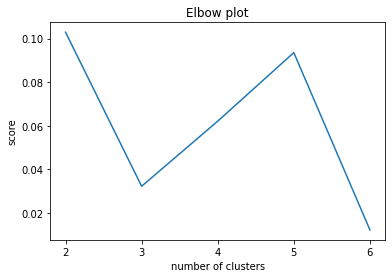

In [0]:
from matplotlib import pyplot as plt

x, y = zip(*cost)
plt.plot(x, y)
plt.title("Elbow plot")
plt.xlabel("number of clusters")
plt.ylabel("score")
plt.xticks(x)
plt.show()

Looks like 3 is a good choice of k.

Let's fit the model.

In [0]:
kmeans = KMeans(k=3, seed=3, featuresCol='features', initMode='random')
model = kmeans.fit(transformed_data)

In [0]:
clusteredData = model.transform(transformed_data)

Number of entries in our clusters:

In [0]:
display(clusteredData
        .groupby('prediction')
        .count()
        .orderBy(F.asc('prediction'))
        .withColumnRenamed('prediction', 'cluster')
        .limit(10))

cluster,count
0,24582
1,484670
2,846920


### Search Engine

We first use the title to retrieve the correct entry from the database. Our solution only recommends similar articles for database entries since the recommendation also requires abstract, keywords and FOS in addition to the title.

We then use the cosine similarity between the TF-IDF vectors to find the N most similar entries from the query entry's cluster.

In [0]:
from pyspark.sql.types import DoubleType

def get_similarity_func(query_vector):
    @udf(DoubleType())
    def dot_product(x):
        return float(x.dot(query_vector))
    
    return dot_product


def recommend(title, data, n=10):
    # L2 normalized vectors (for calculating cosine similarity)
    normalizer = Normalizer(p=2, inputCol="features", outputCol="norm_features")
    normalized_data = normalizer.transform(data)
    
    # our target
    # if duplicate titles exist take first
    matches = normalized_data.filter(F.col("title") == title)
    n_matches = matches.count()
    
    if n_matches == 0:
        logger.info(f"Entry with title '{title}' does not exist")
        return None
    
    if n_matches > 1:
        logger.info(f"Found more than one entry with title '{title}', choosing the first.")        
    
    row = matches.take(1)[0]
    
    query_vector = row.norm_features
    cluster = row.prediction
    
    # dot product between our target vector and other vectors, resulting in cosine similarity
    similarity_func = get_similarity_func(query_vector)
    
    return (normalized_data
            .filter(F.col("title") != title) # remove entries with same titles
            .filter(F.col("prediction") == cluster) # choose from the same cluster
            .select("title", similarity_func(F.col("norm_features")).alias("similarity"))
            .orderBy(F.desc('similarity'))
            .take(n))

Pass a title and the clustered data to the *recommend* function. It will return a dataframe of articles similar to the title. Returns 10 articles by default.

In [0]:
display(recommend("Logic synthesis and verification on fixed topology", clusteredData))

title,similarity
Design for verification testability,0.6550945091361807
Optimal logic synthesis and testability: two faces of the same coin,0.6103461415667851
Design Test: a solution to the problems of ASIC verification,0.5218157818374864
Test generation in circuits constructed by input decomposition,0.5182171962484564
Synthesis of initializable asynchronous circuits,0.5169188428564164
A new dynamic test vector compaction for automatic test pattern generation,0.4938249544181562
Interlocked test generation and digital hardware synthesis,0.49379433225903985
Design Verification by Test Vectors and Arithmetic Transform Universal Test Set,0.49112596442589646
Test vector minimization during logic synthesis,0.48668675783274495
An optimal time expansion model based on combinational ATPG for RT level circuits,0.48355389515101543


In [0]:
display(recommend("Audio-based gender and age identification", clusteredData, n=15))

title,similarity
Age and gender estimation by using facial image,0.5348563613143333
Gender and age estimation from synthetic face images,0.5113343957749169
Learning Age and Gender of Blogger from Stylistic Variation,0.5085300957679528
Language independent voice-based gender identification system,0.5003116521447047
Gender classification in two Emotional Speech databases,0.48635994205994193
Implementation of age and gender recognition system for intelligent digital signage,0.4842384937899233
Emotion-inspired age and gender recognition systems,0.47190243149771766
Investigating the impact of gender development in child-robot interaction,0.46980799010074537
Investigation of Speaker Group-Dependent Modelling for Recognition of Affective States from Speech.,0.4649442253308417
Accurate and privacy preserving cough sensing using a low-cost microphone,0.46414212793090687
